In [2]:
##Librerias 

import pandas as pd
import numpy as np 
import plotly as px
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
from sklearn import tree
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.ensemble import GradientBoostingClassifier
import a_funciones as funciones

pd.set_option('display.max_columns', None) #muestra todas las columnas de tablas
%matplotlib inline

In [3]:
#conexion con sql
conn= sql.connect("db_empleados.db")

In [4]:
#traigo base de datos pre-procesada de sql
df_completo=pd.read_sql("select * from base_full  ",conn)
print("****Numero de registros de la tabla*** \n  ", pd.read_sql("select count(distinct EmployeeID)  from base_full  ",conn))
print(df_completo.info())
#df_completo.describe(include='all')

****Numero de registros de la tabla*** 
      count(distinct EmployeeID)
0                        4410
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   Age                      4410 non-null   float64
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   float64
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   float64
 12  NumCompaniesWorked       4410

In [5]:
#metricas iniciales
print("Enviroent Satisfaccion mean: ",df_completo.EnvironmentSatisfaction.mean())
print("Job Satisfaccion mean: ",df_completo.JobSatisfaction.mean())

Enviroent Satisfaccion mean:  2.725170068027211
Job Satisfaccion mean:  2.7294784580498868


In [6]:
#se corrigen datos int64 que pasan a categoricas y se elimina Employee ID.
df_completo=df_completo.astype({"JobInvolvement":object,"PerformanceRating":object,"EnvironmentSatisfaction":object,"JobSatisfaction":object,"WorkLifeBalance":object,"TrainingTimesLastYear":object,"StockOptionLevel":object,"JobLevel":object,"Education":object })
X=df_completo.drop(["EmployeeID"],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   float64
 4   Education                4410 non-null   object 
 5   EducationField           4410 non-null   object 
 6   Gender                   4410 non-null   object 
 7   JobLevel                 4410 non-null   object 
 8   JobRole                  4410 non-null   object 
 9   MaritalStatus            4410 non-null   object 
 10  MonthlyIncome            4410 non-null   float64
 11  NumCompaniesWorked       4410 non-null   float64
 12  PercentSalaryHike        4410 non-null   float64
 13  StockOptionLevel         4410 non-null   object 
 14  TotalWorkingYears       

In [7]:
##Exportar base de datos completa
df_completo.to_csv("df_completa.csv")

In [8]:
#Separar variable objetivo Attrition y sacarla de la base principal
y = pd.DataFrame(X['Attrition']) # Variable Objetivo
X.drop(['Attrition'], axis = 1, inplace = True)
y.head()

,Attrition
0,No
1,Yes
2,No
3,No
4,No


In [9]:
# LabelEncoder del target
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame(y, columns = ['Attrition'])
print(y.value_counts(), y.shape)

Attrition
0            3699
1             711
dtype: int64 (4410, 1)


/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
#separar variables categoricas y codificarlas
X_object_t=pd.get_dummies(X.select_dtypes(include=['object']))

In [11]:
#Separar variables numericas float
X_float=X.select_dtypes(include=['float'])

In [12]:
#se crea base de datos de X_ final
X_final=pd.concat([X_float,X_object_t],axis=1)
X_final.head()


,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Mean_Work_Hrs,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,TrainingTimesLastYear_0,TrainingTimesLastYear_1,TrainingTimesLastYear_2,TrainingTimesLastYear_3,TrainingTimesLastYear_4,TrainingTimesLastYear_5,TrainingTimesLastYear_6,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,PerformanceRating_3,PerformanceRating_4,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,51.0,6.0,131160.0,1.0,11.0,1.0,1.0,0.0,0.0,7.373651,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
1,31.0,10.0,41890.0,0.0,23.0,6.0,5.0,1.0,4.0,7.718969,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
2,32.0,17.0,193280.0,1.0,15.0,5.0,5.0,0.0,3.0,7.013240,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
3,38.0,2.0,83210.0,3.0,11.0,13.0,8.0,7.0,5.0,7.193678,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
4,32.0,10.0,23420.0,4.0,12.0,9.0,6.0,0.0,4.0,8.006175,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0


In [13]:
X_final.shape

(4410, 75)

In [14]:
##### METODO ALTERNATIVO ESCOGIENDO modelos SEGUN IMPORTANCIA DE VARIABLES EN LOS MODELOS
#Nombre de caracteristicas númericas
numeric_columns=list(X_final.select_dtypes('float64').columns)
#Estandarización de variables
#pipeline=ColumnTransformer([( "std_numericas",StandardScaler() ,numeric_columns)], remainder='passthrough')

#X_trans = pipeline.fit_transform(X_final)
#X_trans_db=pd.DataFrame(X_trans,columns=X_final.columns)


scaler=StandardScaler() #se selecciona el escalado o estandarizacion de variables
scaler.fit(X_final) # se ajusta a la base
X_trans=scaler.transform(X_final)#se aplica a la base
X_trans_db=pd.DataFrame(X_trans,columns=X_final.columns) #se vuelve a convertir en df pandas



In [15]:
# se nombran los modelos con hiperparametros por defecto para compararlos y ya depsues se afinan solo los hiperparametros del mejor
m_ranfor=RandomForestClassifier()
m_dtree=tree.DecisionTreeClassifier()
m_lreg = linear_model.LinearRegression()
m_gbr = XGBRegressor()

In [16]:
#lista con los modelos para funcion sel_variables
modelos=list([m_ranfor,m_dtree, m_lreg, m_gbr])

#se usa funcion sel_variables para comparar los desempeños de los modelos
var_names=funciones.sel_variables(modelos,X_final,y,threshold="1.5*mean")# threshold selecciona los limites de seleccion de importancia de variables, en este caso selecciona la variables que sean dos veces el promedio
var_names.shape #ANTES TENIAMOS 74 VARIABLES

/Users/Vlado/Documents/universidad/11_sem/Analitica3/caso_estudio_HR/a_funciones.py:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X,y)


(30,)

In [17]:
#matriz con variables seleccionadas
X_sel=X_final[var_names]
X_sel

,Age,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,Department_Human Resources,Department_Sales,DistanceFromHome,EducationField_Human Resources,Education_1,EnvironmentSatisfaction_1,EnvironmentSatisfaction_4,Gender_Female,Gender_Male,JobRole_Manufacturing Director,JobRole_Research Director,JobSatisfaction_1,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Single,Mean_Work_Hrs,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear_0,TrainingTimesLastYear_6,WorkLifeBalance_1,WorkLifeBalance_3,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51.0,0,0,0,1,6.0,0,0,0,0,1,0,0,0,0,1,0,0,7.373651,131160.0,1.0,11.0,1.0,0,1,0,0,1.0,0.0,0.0
1,31.0,0,1,0,0,10.0,0,1,0,0,1,0,0,0,0,0,0,1,7.718969,41890.0,0.0,23.0,6.0,0,0,0,0,5.0,1.0,4.0
2,32.0,0,1,0,0,17.0,0,0,0,0,0,1,0,0,0,0,0,0,7.013240,193280.0,1.0,15.0,5.0,0,0,1,0,5.0,0.0,3.0
3,38.0,1,0,0,0,2.0,0,0,0,1,0,1,0,0,0,1,0,0,7.193678,83210.0,3.0,11.0,13.0,0,0,0,1,8.0,7.0,5.0
4,32.0,0,0,0,0,10.0,0,1,0,1,0,1,0,0,1,0,0,1,8.006175,23420.0,4.0,12.0,9.0,0,0,0,1,6.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42.0,0,0,0,0,5.0,0,0,0,1,1,0,0,0,1,0,0,1,8.522277,60290.0,3.0,17.0,10.0,0,0,0,1,3.0,0.0,2.0
4406,29.0,0,0,0,0,2.0,0,0,0,1,0,1,0,0,0,1,1,0,6.092954,26790.0,2.0,15.0,10.0,0,0,0,1,3.0,0.0,2.0
4407,25.0,0,0,0,0,25.0,0,0,1,0,0,1,0,0,0,0,0,0,7.706632,37020.0,0.0,20.0,5.0,0,0,0,1,4.0,1.0,2.0
4408,42.0,0,0,0,1,18.0,0,0,0,1,0,1,0,0,1,0,1,0,9.492595,23980.0,0.0,14.0,10.0,0,0,0,1,9.0,7.0,8.0


In [18]:
#Ya se seleccionaron la variables, ahora se selecciona el mejor modelo, sacando el rmse de cada modelo
#se prueba con la base completa y con la variables seleccionadas
rmse_X_final=funciones.medir_modelos(modelos,"neg_root_mean_squared_error",X_final,y,10) ## base con todas las variables 
rmse_X_sel=funciones.medir_modelos(modelos,"neg_root_mean_squared_error",X_sel,y,10) ### base con variables seleccionadas



/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:

rf        0.000000
dt       -0.075200
rl       -0.331992
gb       -0.038256
rf_Sel    0.000000
dt_sel   -0.059660
rl_sel   -0.332413
gb_Sel   -0.050774
dtype: float64

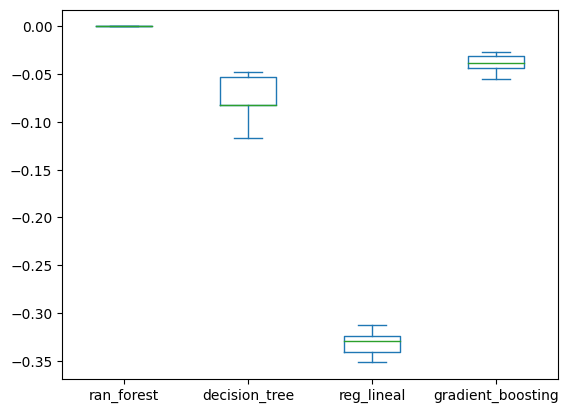

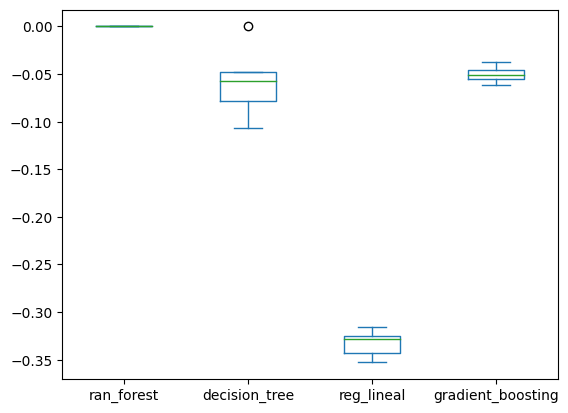

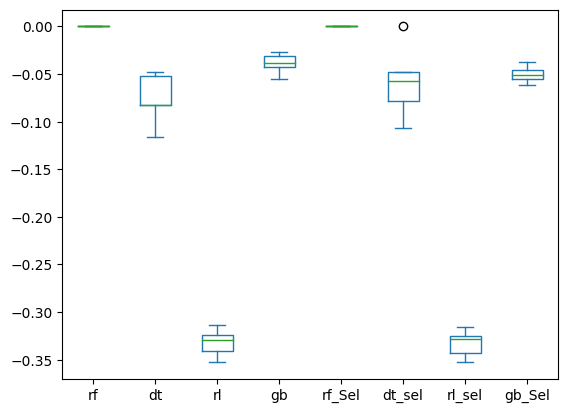

In [19]:
rmse=pd.concat([rmse_X_final,rmse_X_sel],axis=1)
rmse.columns=['rf', 'dt', 'rl', 'gb',
       'rf_Sel', 'dt_sel', 'rl_sel', 'gb_Sel']

rmse_X_final.plot(kind='box') #### gráfico para modelos todas las varibles
rmse_X_sel.plot(kind='box') ### gráfico para modelo variables seleccionadas
rmse.plot(kind='box') ### gráfico para modelos sel y todas las variables

rmse.mean() ### medias de mape

In [ ]:
#el analisis anterior comprueba  que los mejores modelos a los que se les afinarian hiperparametros serian Gradient Boosting, Random Forest y Decision Tree Classifier con variables seleccionadas.
#siendo el mejor rnadom forest y despues gradient boosting.

In [20]:
# Separación en conjuntos de entrenamiento y validación con 80% de muestras para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=1)

#Imprimir Tamaño de dataset, corresponden al 80,20
print("Tamaño del conjunto de entrenamiento. X: ", X_train.shape," Y: ", y_train.shape)
print("Tamaño del conjunto de validación. X: ", X_test.shape," Y: ", y_test.shape )

#Nombre de caracteristicas númericas
numeric_columns=list(X_final.select_dtypes('float64').columns)

#Estandarización de variables
pipeline=ColumnTransformer([( "std_numericas",StandardScaler() , numeric_columns)], remainder='passthrough')

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)# no se hace fit de nuevo(escalar de nuevo) con los datos de test, solo los de train

Tamaño del conjunto de entrenamiento. X:  (3528, 75)  Y:  (3528, 1)
Tamaño del conjunto de validación. X:  (882, 75)  Y:  (882, 1)


##Al ser un ejercicio de clasificacion, se evaluaran 3 modelos los cuales son adecuados para clasificar y lo mas importante, nos permiten saber el peso que tienen las fariables en la respuesta.

Random Forest Classifier

In [21]:
##Random Forest Classifier-Hiperparametros
# Definición de cuadricula de hiperparametros
parameters = {'max_depth': [5,10,15],
              'max_features': [5,7,8],
              'min_samples_split': [7,10],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [300,500,800]}
#modelo estimador
ranfor = RandomForestClassifier(random_state = 1)

#Definir hiperparametros por  busqueda aleatoria
rand_s = RandomizedSearchCV(estimator=ranfor, param_distributions=parameters, n_iter=10, scoring='accuracy', cv=5, verbose=False)

rand_s.fit(X_train, y_train)

print('Best Params: ', rand_s.best_params_)
print('Best Score: ', rand_s.best_score_)

/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:

Best Params:  {'n_estimators': 500, 'min_samples_split': 10, 'max_features': 7, 'max_depth': 15, 'criterion': 'entropy'}
Best Score:  0.9384915516444658


In [28]:
##Random Forest Classifier-Modelo
#Train del modelo
random_forest = RandomForestClassifier(
            n_estimators = 500,
            criterion = 'entropy',
            max_depth = 15,
            min_samples_split = 10,
            max_features = 7,
            # oob_score = False,
            n_jobs = -1,
            # random_state = 1
            # max_leaf_nodes = 10,
         )
random_forest.fit(X_train, y_train)

/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(criterion='entropy', max_depth=15, max_features=7,
                       min_samples_split=10, n_estimators=500, n_jobs=-1)

In [29]:
##Random Forest Classifier-Modelo
#Metricas de desempeño
print ("Train - Accuracy :", metrics.accuracy_score(y_train, random_forest.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, random_forest.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, random_forest.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, random_forest.predict(X_test)))

Train - Accuracy : 0.9912131519274376
Train - classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2979
           1       1.00      0.94      0.97       549

    accuracy                           0.99      3528
   macro avg       0.99      0.97      0.98      3528
weighted avg       0.99      0.99      0.99      3528

Test - Accuracy : 0.9433106575963719
Test - classification report :               precision    recall  f1-score   support

           0       0.94      1.00      0.97       720
           1       1.00      0.69      0.82       162

    accuracy                           0.94       882
   macro avg       0.97      0.85      0.89       882
weighted avg       0.95      0.94      0.94       882



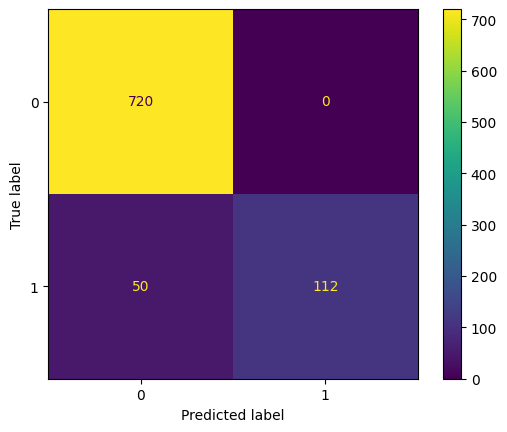

In [30]:
##Random Forest Classifier-Modelo
#Matriz de confusion
cm1= confusion_matrix(y_test, random_forest.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

In [31]:
###Random Forest Classifier-Modelo
#Importancia de las variables
columnas=pd.DataFrame(X_final.columns).rename(columns={0:'columnas'})
importancia=pd.DataFrame(random_forest.feature_importances_).rename(columns={0:'importancia'})
random_forest_var=pd.concat([columnas,importancia], axis=1).sort_values('importancia',ascending=False).head(7)
print(random_forest_var)


               columnas  importancia
9         Mean_Work_Hrs     0.101389
5     TotalWorkingYears     0.070397
0                   Age     0.068455
2         MonthlyIncome     0.054625
6        YearsAtCompany     0.054264
8  YearsWithCurrManager     0.046106
1      DistanceFromHome     0.040662


In [32]:
fig = px.bar(random_forest_var, x='columnas', y='importancia', color = 'columnas',  title ='<b>Importancia de los factores que analiza el modelo<b>')
fig.update_layout(
    xaxis_title = 'Importancia de los factores',
    yaxis_title = 'Factores',
    template = 'plotly_white',
    title_x = 0.5,
    showlegend=False)

Decision Tree Classifier

In [33]:
##Decision Tree Classifier-Hiperparametros
# Definición de cuadricula de hiperparametros
parameters = {'max_depth': [2,10,20],# Maxima profundidad
              'max_features': [3,7,14],# Maximo de caracteristicas a usar
              'max_leaf_nodes': [9,14,15,16,20],#Maximo de nodos
              'min_samples_leaf': [3,4,5,7,10,12],#Minimo de muestras para los nodos hoja
              'criterion': ['gini', 'entropy'],#Medir la cantidad de división.
              'splitter': ['best']}#Estrategia para dividir cada nodo
#modelo estimador
detri = tree.DecisionTreeClassifier(random_state=1)

#Definir hiperparametros por  busqueda aleatoria
rand_s = RandomizedSearchCV(estimator=detri, param_distributions=parameters, n_iter=10, scoring='accuracy', cv=5, verbose=False)
rand_s.fit(X_train, y_train)

print('Best Params: ', rand_s.best_params_)
print('Best Score: ', rand_s.best_score_)

#Definir hiperparametros por  cuadricula

grid_search = GridSearchCV(detri, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

print('Best Params Grid: ', grid_result.best_params_)
print('Best Score Grid: ', grid_result.best_score_)


Best Params:  {'splitter': 'best', 'min_samples_leaf': 12, 'max_leaf_nodes': 20, 'max_features': 14, 'max_depth': 10, 'criterion': 'gini'}
Best Score:  0.8562947782934522
Best Params Grid:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 14, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'splitter': 'best'}
Best Score Grid:  0.8596974263154722


In [34]:
##Decision Tree Classifier-Modelo
#Train del modelo
clf = tree.DecisionTreeClassifier(
          criterion = 'gini', 
          max_depth = 10,
          max_features = 14,
          max_leaf_nodes = 20,
          min_samples_leaf = 5,
          splitter = 'best',
          random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features=14, max_leaf_nodes=20,
                       min_samples_leaf=5, random_state=0)

In [35]:
##Decision Tree Classifier-Modelo
#Metricas de desempeño
print ("Train - Accuracy :", metrics.accuracy_score(y_train, clf.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, clf.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, clf.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, clf.predict(X_test)))

Train - Accuracy : 0.8752834467120182
Train - classification report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      2979
           1       0.82      0.26      0.39       549

    accuracy                           0.88      3528
   macro avg       0.85      0.62      0.66      3528
weighted avg       0.87      0.88      0.85      3528

Test - Accuracy : 0.828798185941043
Test - classification report :               precision    recall  f1-score   support

           0       0.84      0.98      0.90       720
           1       0.62      0.17      0.27       162

    accuracy                           0.83       882
   macro avg       0.73      0.57      0.59       882
weighted avg       0.80      0.83      0.79       882



Profundidad del árbol: 7
Número de nodos terminales: 20


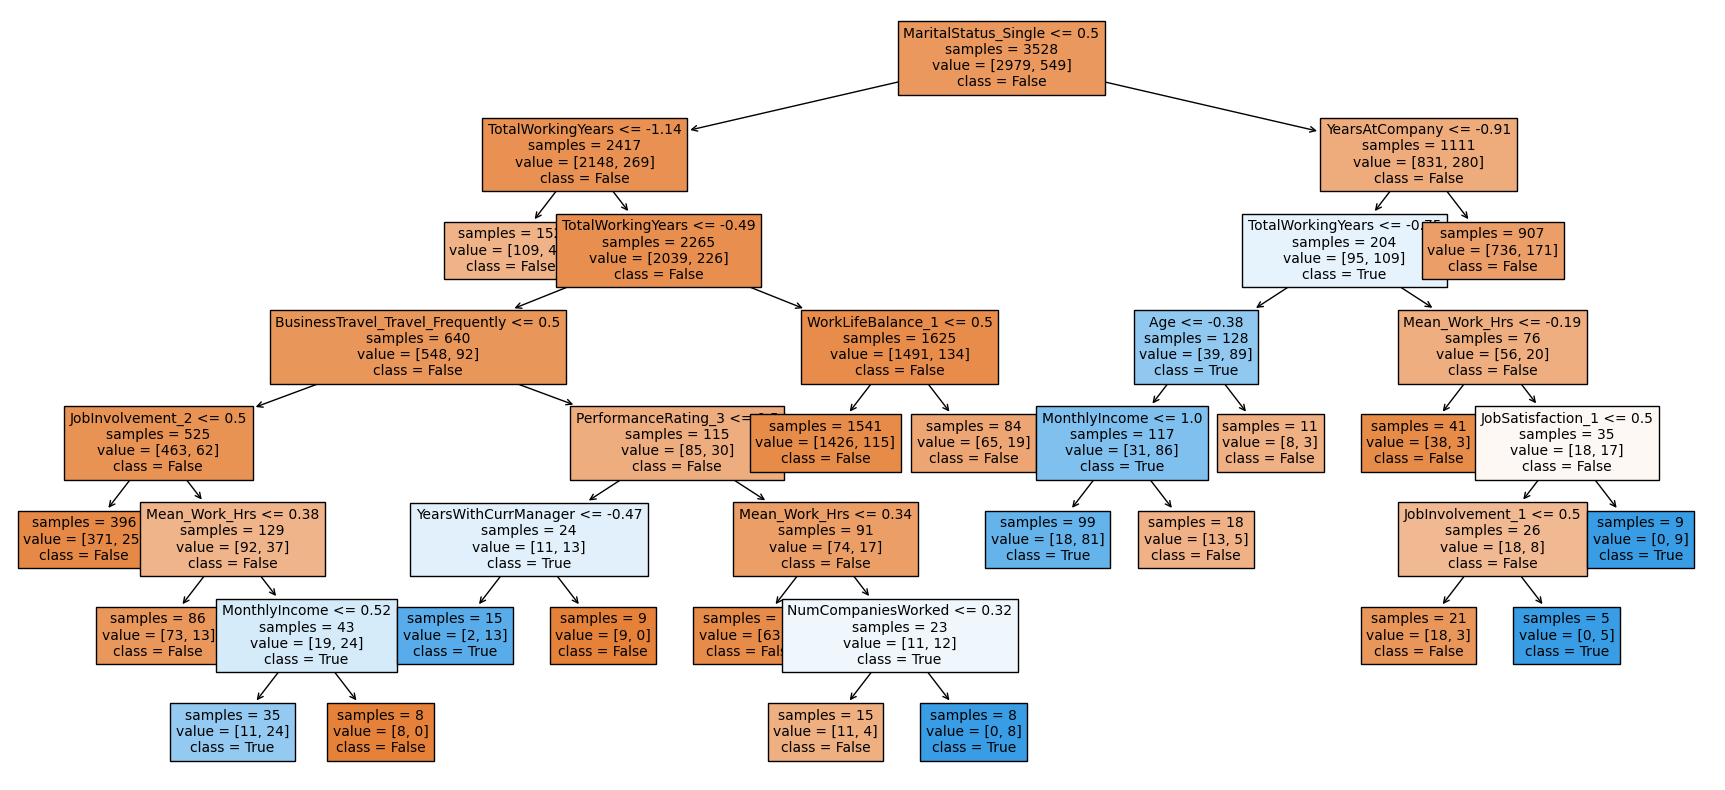

In [36]:
##Decision Tree Classifier-Arbol
fig, ax = plt.subplots(figsize=(22, 10))

print(f"Profundidad del árbol: {clf.get_depth()}")
print(f"Número de nodos terminales: {clf.get_n_leaves()}")

plot = plot_tree(
            decision_tree = clf,
            feature_names = X_final.columns,
            class_names   = ['False', 'True'],
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
        )

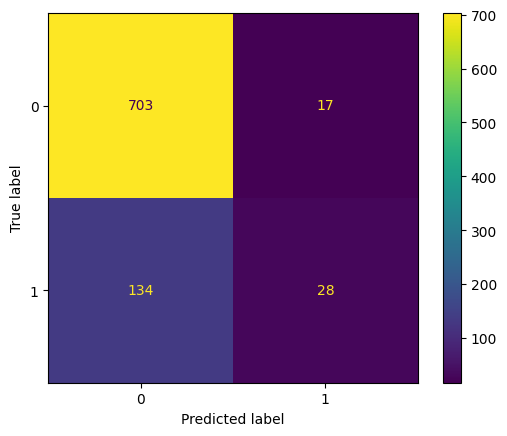

In [37]:
##decision Tree Classifier-Modelo
#Matriz de confusion
cm1= confusion_matrix(y_test, clf.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

In [38]:
###decision Tree Classifier-Modelo
#Importancia de las variables
importancia=pd.DataFrame(clf.feature_importances_).rename(columns={0:'importancia'})
cf=pd.concat([columnas,importancia], axis=1).sort_values('importancia',ascending=False).head(7)
print(cf)

                columnas  importancia
6         YearsAtCompany     0.208111
5      TotalWorkingYears     0.161021
45  MaritalStatus_Single     0.157546
9          Mean_Work_Hrs     0.119294
2          MonthlyIncome     0.078487
58      JobInvolvement_2     0.050885
8   YearsWithCurrManager     0.044157


In [39]:
fig = px.bar(cf, x='columnas', y='importancia', color = 'columnas',  title ='<b>Importancia de los factores que analiza el modelo<b>')
fig.update_layout(
    xaxis_title = 'Importancia de los factores',
    yaxis_title = 'Factores',
    template = 'plotly',
    title_x = 0.5,
    showlegend=False)

Gradient Boosting Classifier

In [40]:
##Gradient Boosting Classifier-Hiperparametros

# Definición de cuadricula de hiperparametros
parameters = {'max_depth': [8,20,30],
              'n_estimators': [100,200,500,800],
              }

#Modelo Estimador
XGBmodel = XGBRegressor(random_state=1)

#Definir hiperparametros por  busqueda aleatoria
rand_s = RandomizedSearchCV(estimator=XGBmodel, param_distributions=parameters, n_iter=10, scoring='accuracy', cv=5, verbose=False)
rand_s.fit(X_train, y_train)
print('Best Params: ', rand_s.best_params_)
print('Best Score: ', rand_s.best_score_)

/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/Users/Vlado/opt/anaconda3/lib/python3.7/site-p

Best Params:  {'n_estimators': 500, 'max_depth': 8}
Best Score:  nan


In [43]:
##Gradient Boosting Classifier-Modelo
#Train del modelo
gboos = GradientBoostingClassifier(
            n_estimators = 500,
            max_depth = 8,
            random_state = 1
         )
gboos.fit(X_train, y_train)

/Users/Vlado/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingClassifier(max_depth=8, n_estimators=500, random_state=1)

In [44]:
##Gradient Boosting Classifier-Modelo
#Metricas de desempeño
print ("Train - Accuracy :", metrics.accuracy_score(y_train, gboos.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, gboos.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, gboos.predict(X_test)))
print ("Test - classification report :\n", metrics.classification_report(y_test, gboos.predict(X_test)))

Train - Accuracy : 1.0
Train - classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2979
           1       1.00      1.00      1.00       549

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528

Test - Accuracy : 0.9852607709750567
Test - classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       720
           1       1.00      0.92      0.96       162

    accuracy                           0.99       882
   macro avg       0.99      0.96      0.97       882
weighted avg       0.99      0.99      0.99       882



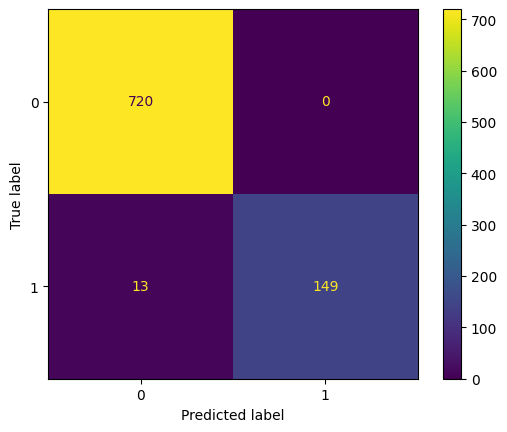

In [45]:
##Gradient Boosting Classifier-Modelo
#Matriz de confusion
cm1= confusion_matrix(y_test, gboos.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

In [46]:
##Gradient Boosting Classifier-Modelo
#Importancia de las variables
importancia=pd.DataFrame(gboos.feature_importances_).rename(columns={0:'importancia'})
gboos_var=pd.concat([columnas,importancia], axis=1).sort_values('importancia',ascending=False).head(10)
gboos_var

,columnas,importancia
9,Mean_Work_Hrs,0.124670
5,TotalWorkingYears,0.115311
2,MonthlyIncome,0.078504
0,Age,0.071158
45,MaritalStatus_Single,0.044428
7,YearsSinceLastPromotion,0.043765
1,DistanceFromHome,0.038968
3,NumCompaniesWorked,0.038804
8,YearsWithCurrManager,0.035807
6,YearsAtCompany,0.031526


In [47]:
fig = px.bar(gboos_var, x='columnas', y='importancia', color = 'columnas',  title ='<b>Importancia de los factores que analiza el modelo<b>')
fig.update_layout(
    xaxis_title = 'Importancia de los factores',
    yaxis_title = 'Factores',
    template = 'plotly',
    title_x = 0.5,
    showlegend=False)